# Generative Adversarial Networks

* **Learning Objective:** In this problem, you will implement a Generative Adversarial Network with the network structure proposed in [*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434), and learn a visualization technique, *activation maximization*.


In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Introduction: The forger versus the police

*Note: read the story even if you are already familiar with GANs, as one of the questions is related to this story.*

Generative models try to model the distribution of the data in an explicit way, in the sense that we can easily sample new data points from this model. This is in contrast to discriminative models that try to infer the output from the input. In the class we have seen one classic deep generative model, the Variational Autoencoder (VAE). Here, we will learn another generative model that has risen to prominence in recent years, the Generative Adversarial Network (GAN).

As the maths of Generative Adversarial Networks is somewhat tedious, a story is often told of a forger and a police to illustrate the idea.

> Imagine a forger that makes fake bills, and a police that tries to find these forgeries. If the forger were a VAE, his goal would be to take some real bills, and try to replicate the real bills as precisely as possible. In GAN, he has a different idea in his mind: rather than trying to replicate the real bills, it suffices to make fake bills such that people *think* they are real.
> 
> Now let's start. In the beginning, the police knows nothing about how to distinguish between real and fake bills. The forger knows nothing either and only produces white paper.
> 
> In the first round, the police gets the fake bill and learns that the forgeries are white while the real bills are green. The forger then finds out that white papers can no longer fool the police and starts to produce green papers.
>
> In the second round, the police learns that real bills have denominations printed on them while the forgeries do not. The forger then finds out that plain papers can no longer fool the police and starts to print numbers on them.
>
> In the third round, the police learns that real bills have watermarks on them while the forgeries do not. The forger then has to reproduce the watermarks on his fake bills.
>
> ...
>
> Finally, the police is able to spot the tiniest difference between real and fake bills and the forger has to make perfect replicas of real bills to fool the police.

Now in a GAN, the forger becomes the generator and the police becomes the discriminator. The discriminator is a binary classifier with the two classes being "taken from the real data" ("real") and "generated by the generator" ("fake"). Its objective is to minimize the classification loss. The generator's objective is to generate samples so that the discriminator misclassifies them as real.

Here we have some complications: the goal is not to find one perfect fake sample. Such a sample will not actually fool the discriminator: if the forger makes hundreds of the exact same fake bill, they will all have the same serial number and the police will soon find out that they are fake. Instead, we want the generator to be able to generate a variety of fake samples such that when presented as a distribution alongside the distribution of real samples, these two are indistinguishable by the discriminator.

So how do we generate different samples with a diterministic generator? We provide it with random numbers as input.

Typically, for the discriminator we use binary cross entropy loss with label 1 being real and 0 being fake. For the generator, the input is a random vector drawn from a standard normal distribution. Denote the generator by $G_{\phi}(z)$, discriminator by $D_{\theta}(x)$, the distribution of the real samples by $p(x)$ and the input distribution to the generator by $q(z)$. Recall that the binary cross entropy loss with classifier output $y$ and label $\hat{y}$ is

$$L(y, \hat{y}) = -\hat{y} \log y - (1 - \hat{y}) \log (1 - y)$$

For the discriminator, the objective is

$$\min_{\theta} \mathrm{E}_{x \sim p(x)}[L(D_{\theta}(x), 1)] + \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

For the generator, the objective is

$$\max_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

The generator's objective corresponds to maximizing the classification loss of the discriminator on the generated samples. Alternatively, we can **minimize** the classification loss of the discriminator on the generated samples  **when labelled as real**:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

And this is what we will use in our implementation. The strength of the two networks should be balanced, so we train the two networks alternatingly, updating the parameters in both networks once in each interation.

## Implementing the GAN 

We first load the data (CIFAR-10) and define some convenient functions. You should already have CIFAR-10 from assignment 1. Just copy the data from there or use ```data/get_datasets.sh``` if you don't have them.

In [2]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples = load_test_data() / 255.0

In [3]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

To save you some mundane work, we have defined a discriminator and a generator for you, in ```_discriminator()``` and ```_generator()``` respectively. Look at the code to see what layers are there.

For this part, you need to complete code blocks marked with "Prob 2-1":

*   **Build the computation graph for the losses:** Complete the following definitions in ```_init_ops()```
    *   ```fake_samples_op```: generate famples from ```noise```
    *   ```dis_loss_op```: compute discriminator's loss, with real samples from ```real_input``` and fake
        samples generated by the generator
    *   ```gen_loss_op```: compute generator's loss
*   **Define the optimizer:** We use RMSprop for training. Adam is observed to perform poorly with an unstable objective as is the case in GANs. We've defined ```dis_train_op``` and ```gen_train_op``` for you but those are wrong: rather than updating all the parameters all the time, when training one network we want to keep the other one fixed. Modify the definition to reflect this. [Check here](https://stackoverflow.com/a/35304001) if you are not sure how this is possible.
*   **Feed the data:** Feed the proper samples and labels in ```train()``` for training and in ```generate_one_sample()``` for visualizing the generated samples.

The batch normalization layers should operate in training mode. As per *[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)*, we put real samples and fake samples in different batches when training the discriminator.

*Note: use the advices on that page with caution if you are doing GAN for your team project. It is already more than 2 years old, which is a **really long time** in deep learning research. It does not reflect the latest results.*

In [4]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 15
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        
        self.fake_samples_op = self._generator(self.noise)
        self.dis_loss_op = self._loss(self.real_label, self._discriminator(self.real_input)) +\
        self._loss(self.fake_label, self._discriminator(self.fake_samples_op))
        # print(self.dis_loss_op.shape)
        self.gen_loss_op = self._loss(self.real_label,self._discriminator(self.fake_samples_op))
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        
        dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dis')
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list=dis_var)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        gen_v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'gen')
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                   var_list=gen_v)
        ################################################################################
        # Prob 2-2: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)
        
        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-2: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.recon_loss_op = self._reconstruction_loss(self.recon_sample, self.actmax_sample_op)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list=[self.actmax_code])
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                # axis = 0
                dis_feed_dict = {
                    self.real_input:batch_samples,
                    self.real_label:ones,
                    self.noise:noise,
                    self.fake_label:zeros,
                    self.is_train:True}
        
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                # same as dis, for ease, although fakelabels not needed
                gen_feed_dict = {
                    self.real_input:batch_samples,
                    self.real_label:ones, 
                    self.noise:noise,
                    self.fake_label:zeros,
                    self.is_train:True}

                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        ################################################################################
        # Prob 2-2: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        actmax_init_val = tf.zeros(self.actmax_code.shape, dtype=tf.float32)
        # print(self.actmax_code.shape)
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-2: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-2     #
            ################################################################################   
            recon_feed_dict = {
                self.recon_sample: sample,
                self.actmax_label:np.ones([1, 1]),
                self.is_train: False}

            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        gen_vis_feed_dict = {
            self.noise:code,
            self.fake_label:np.ones([1,1]),
            self.is_train:False}
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-2: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

Now let's do the training!

Don't panic if the loss curve goes wild. The two networks are competing for the loss curve to go different directions, so virtually anything can happen. If your code is correct, the generated samples should have a high variety.

W1024 12:18:42.857125 139648361588544 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1024 12:18:43.067012 139648361588544 deprecation.py:323] From /home/hensden/usc/fall19/deeplearning/assignment2/csci566-assignment2/venv2/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1024 12:18:43.508824 139648361588544 deprecation.py:506] From /home/hensden/usc/fall19/deeplearning/assignment2/csci566-assignment2/venv2/lib/pyth

Start training ...
Iteration 50/23430: dis loss = 0.4688, gen loss = 2.1450
Iteration 100/23430: dis loss = 0.0752, gen loss = 4.0181
Iteration 150/23430: dis loss = 0.1893, gen loss = 5.2799
Iteration 200/23430: dis loss = 0.1900, gen loss = 2.8303
Iteration 250/23430: dis loss = 0.0447, gen loss = 4.2861
Iteration 300/23430: dis loss = 0.3140, gen loss = 1.2166
Iteration 350/23430: dis loss = 0.6621, gen loss = 1.3388
Iteration 400/23430: dis loss = 0.5714, gen loss = 1.7199
Iteration 450/23430: dis loss = 0.6174, gen loss = 1.6331
Iteration 500/23430: dis loss = 0.6176, gen loss = 3.0264
Iteration 550/23430: dis loss = 0.8476, gen loss = 1.7110
Iteration 600/23430: dis loss = 0.7100, gen loss = 2.0057
Iteration 650/23430: dis loss = 1.0045, gen loss = 2.0921
Iteration 700/23430: dis loss = 0.8517, gen loss = 0.9307
Iteration 750/23430: dis loss = 0.6084, gen loss = 2.1955
Iteration 800/23430: dis loss = 0.4505, gen loss = 2.0060
Iteration 850/23430: dis loss = 0.7803, gen loss = 1.6

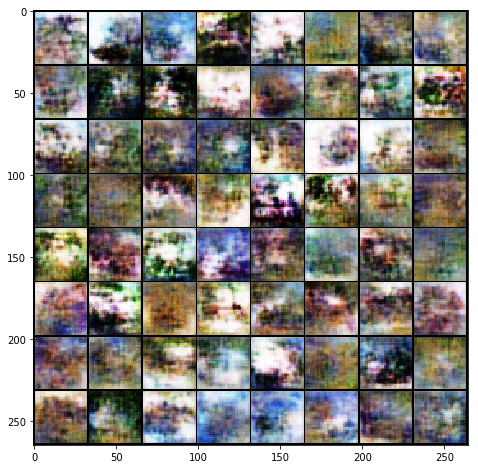

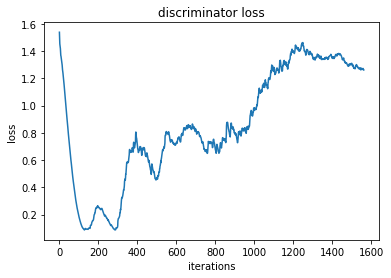

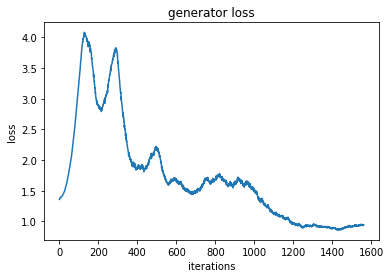

Iteration 1600/23430: dis loss = 1.2598, gen loss = 1.3280
Iteration 1650/23430: dis loss = 1.1439, gen loss = 0.8305
Iteration 1700/23430: dis loss = 1.1403, gen loss = 1.3368
Iteration 1750/23430: dis loss = 1.1463, gen loss = 0.8748
Iteration 1800/23430: dis loss = 1.5612, gen loss = 1.2036
Iteration 1850/23430: dis loss = 1.2891, gen loss = 0.6872
Iteration 1900/23430: dis loss = 1.0517, gen loss = 1.2323
Iteration 1950/23430: dis loss = 1.1644, gen loss = 1.2184
Iteration 2000/23430: dis loss = 1.3959, gen loss = 1.6085
Iteration 2050/23430: dis loss = 1.1818, gen loss = 1.1128
Iteration 2100/23430: dis loss = 1.1722, gen loss = 0.7695
Iteration 2150/23430: dis loss = 1.2775, gen loss = 0.7040
Iteration 2200/23430: dis loss = 1.2146, gen loss = 0.8307
Iteration 2250/23430: dis loss = 1.2752, gen loss = 0.6583
Iteration 2300/23430: dis loss = 1.2137, gen loss = 1.0440
Iteration 2350/23430: dis loss = 1.0498, gen loss = 1.0553
Iteration 2400/23430: dis loss = 1.2678, gen loss = 0.75

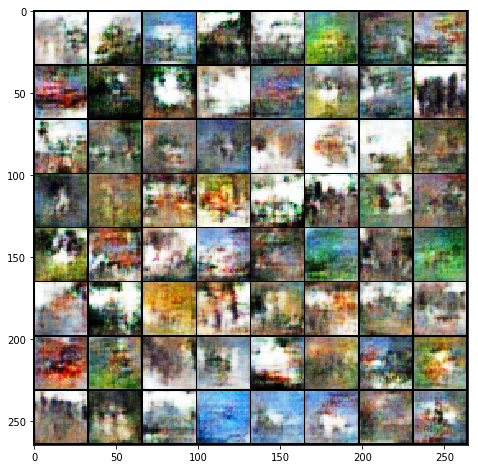

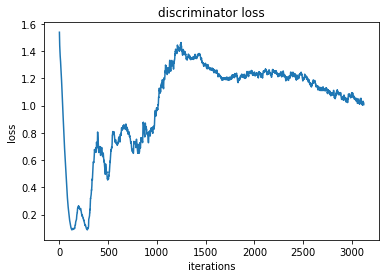

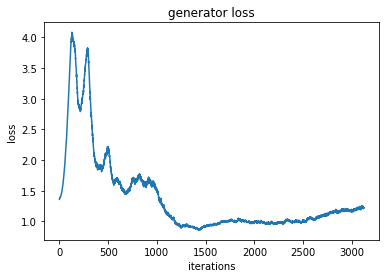

Iteration 3150/23430: dis loss = 1.0271, gen loss = 0.7056
Iteration 3200/23430: dis loss = 0.9373, gen loss = 1.6325
Iteration 3250/23430: dis loss = 0.9456, gen loss = 0.8945
Iteration 3300/23430: dis loss = 0.9356, gen loss = 1.0202
Iteration 3350/23430: dis loss = 1.0185, gen loss = 0.7378
Iteration 3400/23430: dis loss = 1.1946, gen loss = 1.7052
Iteration 3450/23430: dis loss = 0.9215, gen loss = 1.7957
Iteration 3500/23430: dis loss = 0.9646, gen loss = 1.0140
Iteration 3550/23430: dis loss = 1.0109, gen loss = 1.6605
Iteration 3600/23430: dis loss = 1.0992, gen loss = 1.5304
Iteration 3650/23430: dis loss = 0.8806, gen loss = 0.8325
Iteration 3700/23430: dis loss = 1.0725, gen loss = 0.7029
Iteration 3750/23430: dis loss = 0.9280, gen loss = 0.7902
Iteration 3800/23430: dis loss = 1.6098, gen loss = 1.8143
Iteration 3850/23430: dis loss = 0.8244, gen loss = 1.1123
Iteration 3900/23430: dis loss = 0.8437, gen loss = 1.1824
Iteration 3950/23430: dis loss = 0.9149, gen loss = 1.59

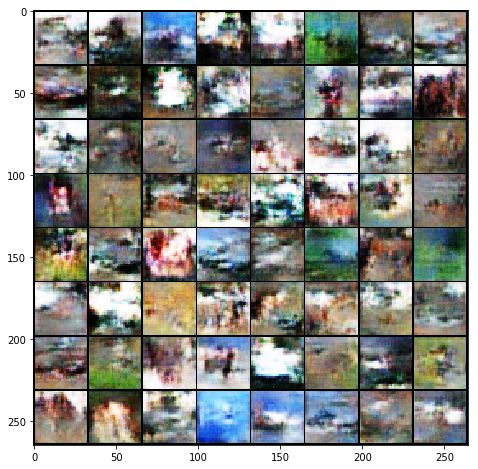

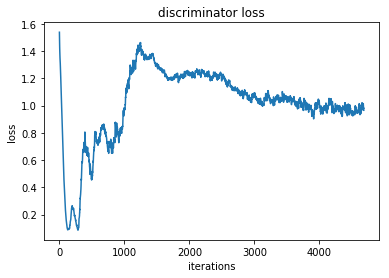

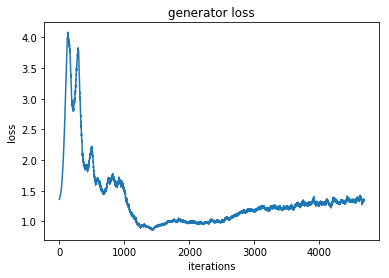

Iteration 4700/23430: dis loss = 0.8150, gen loss = 1.2461
Iteration 4750/23430: dis loss = 1.1642, gen loss = 0.7881
Iteration 4800/23430: dis loss = 1.1914, gen loss = 0.5950
Iteration 4850/23430: dis loss = 1.2155, gen loss = 0.7404
Iteration 4900/23430: dis loss = 0.6674, gen loss = 1.1585
Iteration 4950/23430: dis loss = 1.1346, gen loss = 0.9247
Iteration 5000/23430: dis loss = 1.0657, gen loss = 0.8594
Iteration 5050/23430: dis loss = 0.9101, gen loss = 0.9006
Iteration 5100/23430: dis loss = 1.0860, gen loss = 2.0947
Iteration 5150/23430: dis loss = 0.9063, gen loss = 1.8085
Iteration 5200/23430: dis loss = 0.9512, gen loss = 1.0225
Iteration 5250/23430: dis loss = 0.9187, gen loss = 1.4521
Iteration 5300/23430: dis loss = 1.0275, gen loss = 1.6541
Iteration 5350/23430: dis loss = 0.7831, gen loss = 2.3405
Iteration 5400/23430: dis loss = 1.1700, gen loss = 0.7466
Iteration 5450/23430: dis loss = 1.2186, gen loss = 1.8238
Iteration 5500/23430: dis loss = 0.8245, gen loss = 1.69

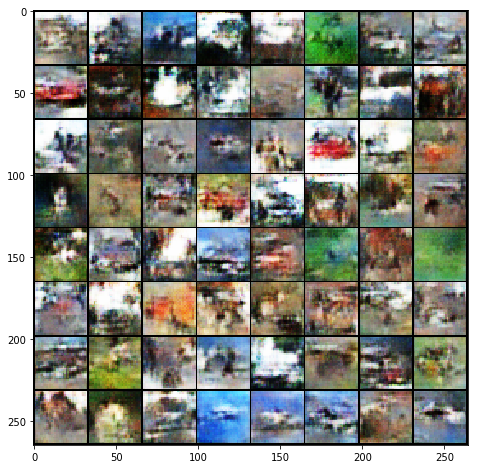

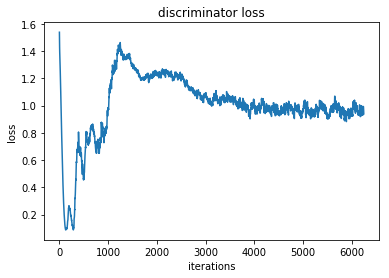

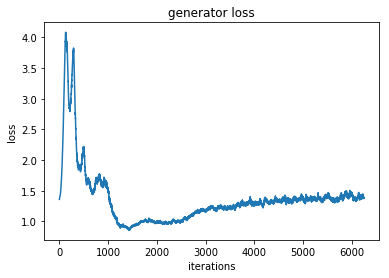

Iteration 6250/23430: dis loss = 1.1661, gen loss = 0.7080
Iteration 6300/23430: dis loss = 1.2788, gen loss = 0.9793
Iteration 6350/23430: dis loss = 1.1100, gen loss = 0.6455
Iteration 6400/23430: dis loss = 1.1172, gen loss = 1.7223
Iteration 6450/23430: dis loss = 0.5643, gen loss = 1.5344
Iteration 6500/23430: dis loss = 0.8345, gen loss = 0.7762
Iteration 6550/23430: dis loss = 1.0746, gen loss = 2.6155
Iteration 6600/23430: dis loss = 0.7317, gen loss = 1.1286
Iteration 6650/23430: dis loss = 1.1090, gen loss = 0.8947
Iteration 6700/23430: dis loss = 0.7594, gen loss = 2.0547
Iteration 6750/23430: dis loss = 1.1055, gen loss = 0.6080
Iteration 6800/23430: dis loss = 0.9639, gen loss = 1.2729
Iteration 6850/23430: dis loss = 0.8500, gen loss = 1.9358
Iteration 6900/23430: dis loss = 0.8823, gen loss = 1.7915
Iteration 6950/23430: dis loss = 0.9751, gen loss = 0.6965
Iteration 7000/23430: dis loss = 1.0345, gen loss = 0.7794
Iteration 7050/23430: dis loss = 0.7803, gen loss = 1.16

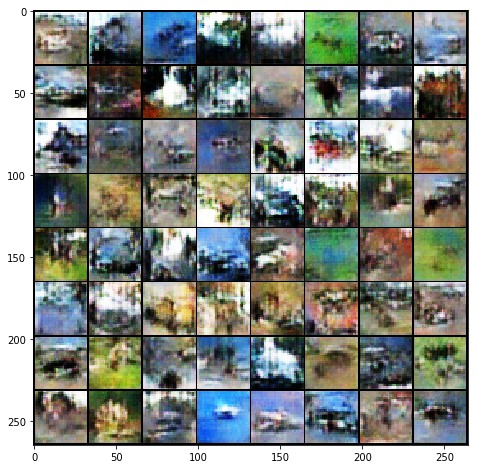

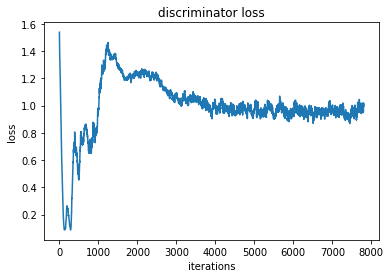

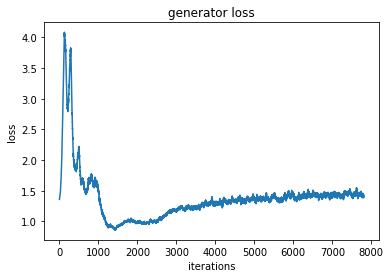

Iteration 7850/23430: dis loss = 1.0435, gen loss = 2.1787
Iteration 7900/23430: dis loss = 0.7149, gen loss = 2.2310
Iteration 7950/23430: dis loss = 1.4133, gen loss = 2.5958
Iteration 8000/23430: dis loss = 1.2768, gen loss = 1.8665
Iteration 8050/23430: dis loss = 0.7304, gen loss = 2.0053
Iteration 8100/23430: dis loss = 1.3486, gen loss = 1.9305
Iteration 8150/23430: dis loss = 0.7486, gen loss = 1.3131
Iteration 8200/23430: dis loss = 1.0811, gen loss = 2.2085
Iteration 8250/23430: dis loss = 1.0027, gen loss = 0.8942
Iteration 8300/23430: dis loss = 0.9204, gen loss = 1.1399
Iteration 8350/23430: dis loss = 0.8368, gen loss = 1.0415
Iteration 8400/23430: dis loss = 0.7659, gen loss = 1.1484
Iteration 8450/23430: dis loss = 1.0120, gen loss = 1.6274
Iteration 8500/23430: dis loss = 1.0439, gen loss = 0.9108
Iteration 8550/23430: dis loss = 0.9961, gen loss = 1.9955
Iteration 8600/23430: dis loss = 0.7875, gen loss = 0.7268
Iteration 8650/23430: dis loss = 1.0534, gen loss = 1.07

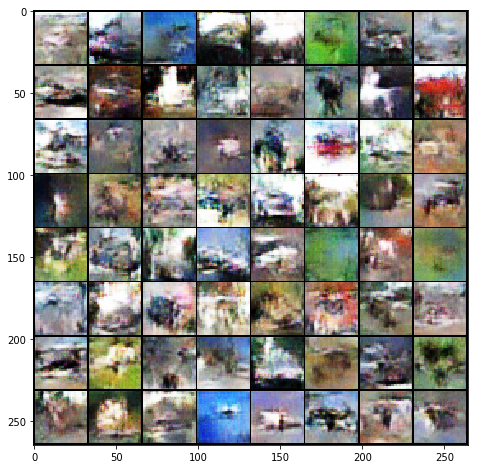

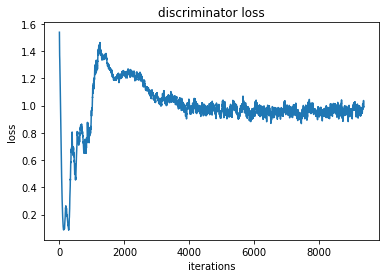

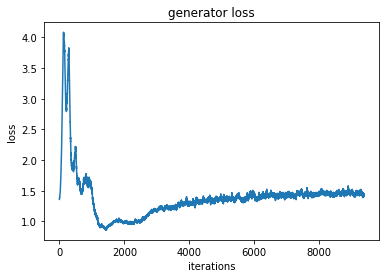

Iteration 9400/23430: dis loss = 1.0457, gen loss = 1.9204
Iteration 9450/23430: dis loss = 0.9192, gen loss = 2.1529
Iteration 9500/23430: dis loss = 0.9096, gen loss = 1.9773
Iteration 9550/23430: dis loss = 1.0277, gen loss = 2.6139
Iteration 9600/23430: dis loss = 1.0988, gen loss = 2.9542
Iteration 9650/23430: dis loss = 0.9439, gen loss = 1.0679
Iteration 9700/23430: dis loss = 0.8536, gen loss = 1.0666
Iteration 9750/23430: dis loss = 0.4246, gen loss = 1.9398
Iteration 9800/23430: dis loss = 0.6550, gen loss = 1.5577
Iteration 9850/23430: dis loss = 0.8481, gen loss = 0.9636
Iteration 9900/23430: dis loss = 0.6968, gen loss = 2.0029
Iteration 9950/23430: dis loss = 1.0871, gen loss = 2.0132
Iteration 10000/23430: dis loss = 1.1637, gen loss = 0.6328
Iteration 10050/23430: dis loss = 1.6041, gen loss = 0.4925
Iteration 10100/23430: dis loss = 0.9503, gen loss = 1.5461
Iteration 10150/23430: dis loss = 1.0471, gen loss = 0.8743
Iteration 10200/23430: dis loss = 1.2079, gen loss =

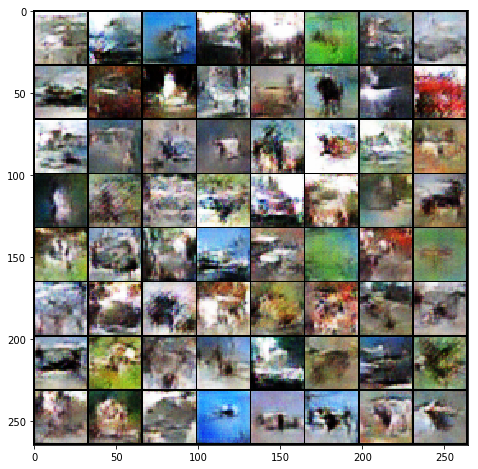

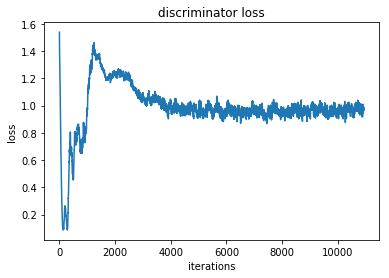

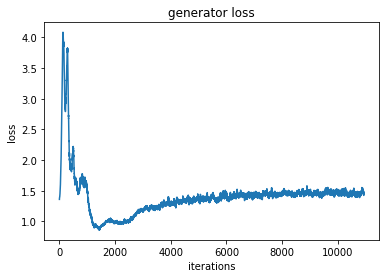

Iteration 10950/23430: dis loss = 0.8399, gen loss = 1.7582
Iteration 11000/23430: dis loss = 0.7914, gen loss = 1.2828
Iteration 11050/23430: dis loss = 1.3472, gen loss = 1.9801
Iteration 11100/23430: dis loss = 1.0692, gen loss = 1.1042
Iteration 11150/23430: dis loss = 1.1349, gen loss = 1.1964
Iteration 11200/23430: dis loss = 0.7379, gen loss = 1.4894
Iteration 11250/23430: dis loss = 0.5551, gen loss = 2.0462
Iteration 11300/23430: dis loss = 0.6678, gen loss = 1.3154
Iteration 11350/23430: dis loss = 0.8928, gen loss = 1.6295
Iteration 11400/23430: dis loss = 1.0300, gen loss = 0.6888
Iteration 11450/23430: dis loss = 1.1440, gen loss = 0.5828
Iteration 11500/23430: dis loss = 0.8100, gen loss = 1.3033
Iteration 11550/23430: dis loss = 0.8983, gen loss = 2.1967
Iteration 11600/23430: dis loss = 0.8610, gen loss = 0.9079
Iteration 11650/23430: dis loss = 0.9732, gen loss = 1.1655
Iteration 11700/23430: dis loss = 0.8585, gen loss = 1.2286
Iteration 11750/23430: dis loss = 0.7885

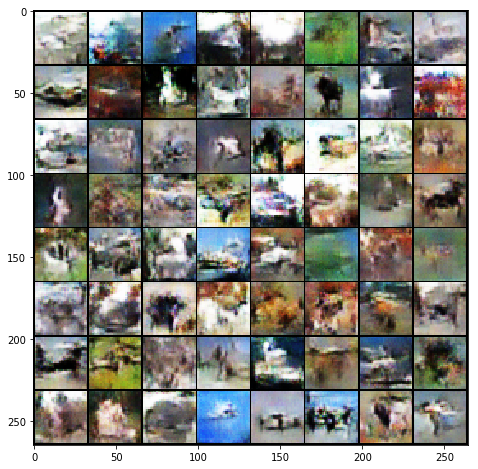

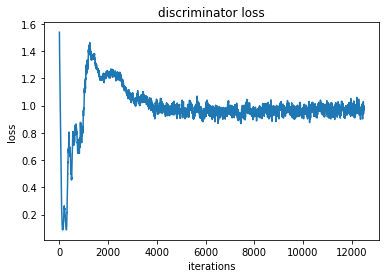

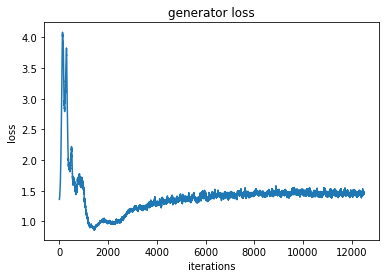

Iteration 12500/23430: dis loss = 0.8652, gen loss = 1.1688
Iteration 12550/23430: dis loss = 0.6666, gen loss = 1.2716
Iteration 12600/23430: dis loss = 0.9980, gen loss = 0.6948
Iteration 12650/23430: dis loss = 1.0357, gen loss = 1.8081
Iteration 12700/23430: dis loss = 1.1082, gen loss = 2.2693
Iteration 12750/23430: dis loss = 0.8186, gen loss = 1.5269
Iteration 12800/23430: dis loss = 1.0677, gen loss = 2.2972
Iteration 12850/23430: dis loss = 0.8551, gen loss = 1.3499
Iteration 12900/23430: dis loss = 1.4845, gen loss = 0.4692
Iteration 12950/23430: dis loss = 0.9094, gen loss = 1.4463
Iteration 13000/23430: dis loss = 0.6906, gen loss = 1.8179
Iteration 13050/23430: dis loss = 1.0715, gen loss = 2.2260
Iteration 13100/23430: dis loss = 0.8055, gen loss = 2.0999
Iteration 13150/23430: dis loss = 1.0547, gen loss = 1.2881
Iteration 13200/23430: dis loss = 1.0362, gen loss = 0.9819
Iteration 13250/23430: dis loss = 1.0963, gen loss = 0.9552
Iteration 13300/23430: dis loss = 0.9143

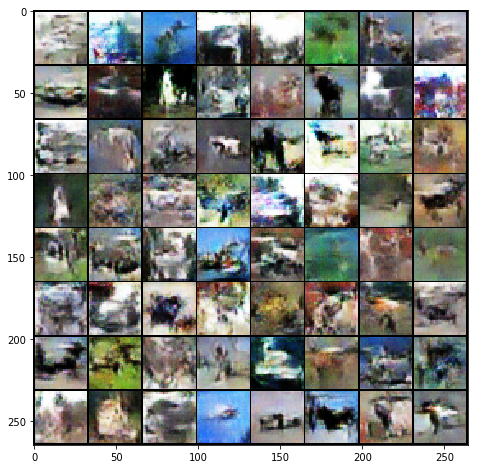

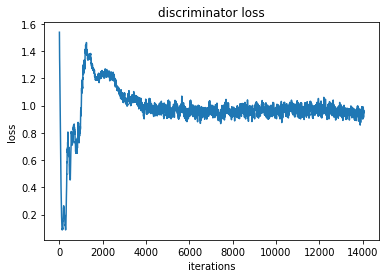

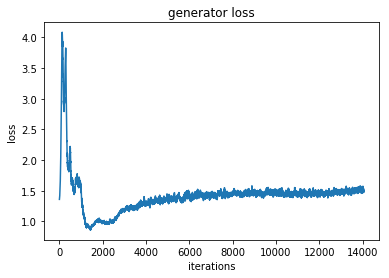

Iteration 14100/23430: dis loss = 1.0522, gen loss = 2.1769
Iteration 14150/23430: dis loss = 0.7529, gen loss = 1.4320
Iteration 14200/23430: dis loss = 1.1283, gen loss = 1.8267
Iteration 14250/23430: dis loss = 0.8723, gen loss = 0.9456
Iteration 14300/23430: dis loss = 0.9478, gen loss = 2.3816
Iteration 14350/23430: dis loss = 1.1532, gen loss = 2.1965
Iteration 14400/23430: dis loss = 0.9045, gen loss = 0.8833
Iteration 14450/23430: dis loss = 0.7850, gen loss = 1.0001
Iteration 14500/23430: dis loss = 0.7434, gen loss = 1.1319
Iteration 14550/23430: dis loss = 0.8190, gen loss = 1.7165
Iteration 14600/23430: dis loss = 0.9604, gen loss = 1.1520
Iteration 14650/23430: dis loss = 0.7554, gen loss = 1.6322
Iteration 14700/23430: dis loss = 1.3559, gen loss = 2.5204
Iteration 14750/23430: dis loss = 1.0609, gen loss = 0.7721
Iteration 14800/23430: dis loss = 0.6831, gen loss = 1.2395
Iteration 14850/23430: dis loss = 0.6316, gen loss = 2.3256
Iteration 14900/23430: dis loss = 0.8672

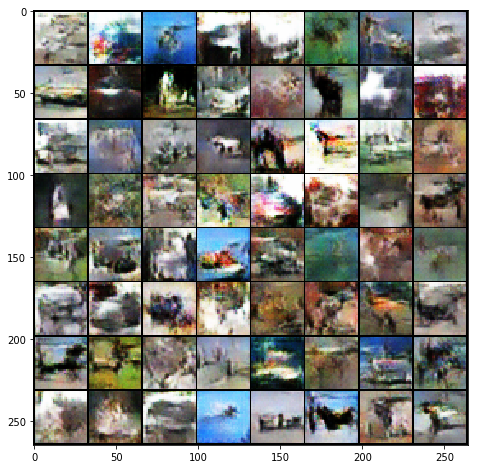

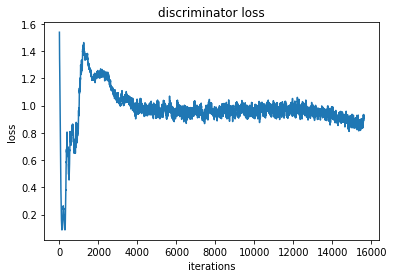

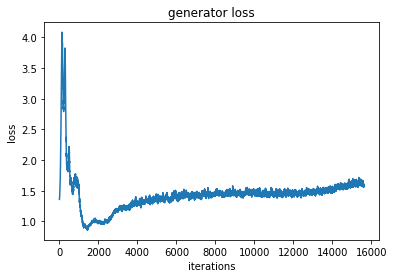

Iteration 15650/23430: dis loss = 0.8263, gen loss = 1.6558
Iteration 15700/23430: dis loss = 0.7781, gen loss = 1.0322
Iteration 15750/23430: dis loss = 0.7478, gen loss = 1.1673
Iteration 15800/23430: dis loss = 0.8998, gen loss = 2.5068
Iteration 15850/23430: dis loss = 0.9106, gen loss = 0.9471
Iteration 15900/23430: dis loss = 1.1312, gen loss = 2.6528
Iteration 15950/23430: dis loss = 0.6806, gen loss = 1.8079
Iteration 16000/23430: dis loss = 1.0339, gen loss = 2.0129
Iteration 16050/23430: dis loss = 1.0115, gen loss = 2.3718
Iteration 16100/23430: dis loss = 1.0333, gen loss = 1.7605
Iteration 16150/23430: dis loss = 0.8563, gen loss = 2.0008
Iteration 16200/23430: dis loss = 1.1855, gen loss = 0.9569
Iteration 16250/23430: dis loss = 0.6991, gen loss = 2.0525
Iteration 16300/23430: dis loss = 0.7167, gen loss = 1.4615
Iteration 16350/23430: dis loss = 0.7221, gen loss = 1.7076
Iteration 16400/23430: dis loss = 0.8208, gen loss = 2.7560
Iteration 16450/23430: dis loss = 0.8353

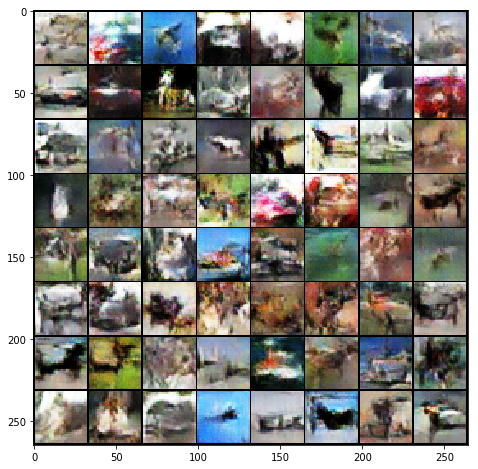

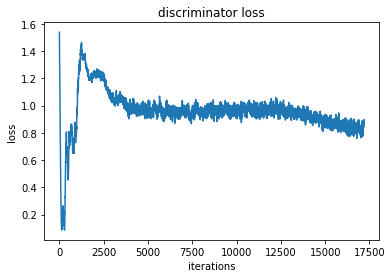

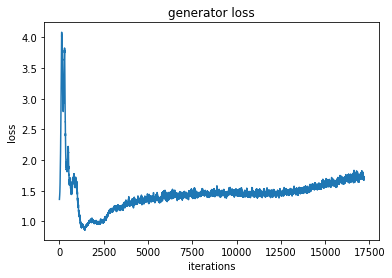

Iteration 17200/23430: dis loss = 0.7671, gen loss = 3.2076
Iteration 17250/23430: dis loss = 0.8636, gen loss = 0.9627
Iteration 17300/23430: dis loss = 1.0825, gen loss = 1.9516
Iteration 17350/23430: dis loss = 0.8901, gen loss = 0.8910
Iteration 17400/23430: dis loss = 0.5380, gen loss = 1.4384
Iteration 17450/23430: dis loss = 0.7048, gen loss = 1.4508
Iteration 17500/23430: dis loss = 0.7001, gen loss = 2.4613
Iteration 17550/23430: dis loss = 0.7962, gen loss = 2.5719
Iteration 17600/23430: dis loss = 0.9684, gen loss = 2.3013
Iteration 17650/23430: dis loss = 0.7904, gen loss = 2.6225
Iteration 17700/23430: dis loss = 0.6766, gen loss = 1.4909
Iteration 17750/23430: dis loss = 0.7912, gen loss = 1.8186
Iteration 17800/23430: dis loss = 0.9232, gen loss = 2.6128
Iteration 17850/23430: dis loss = 0.6302, gen loss = 2.4335
Iteration 17900/23430: dis loss = 1.0740, gen loss = 0.6667
Iteration 17950/23430: dis loss = 0.6260, gen loss = 2.4237
Iteration 18000/23430: dis loss = 0.8616

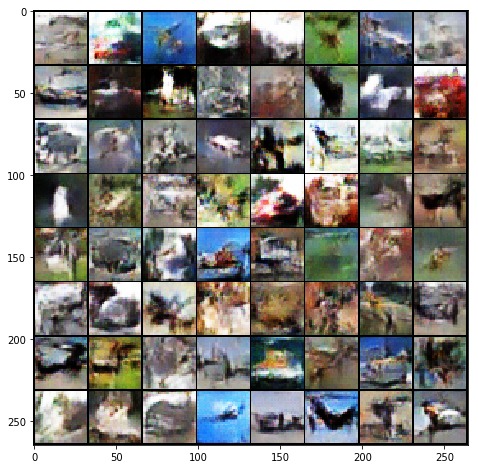

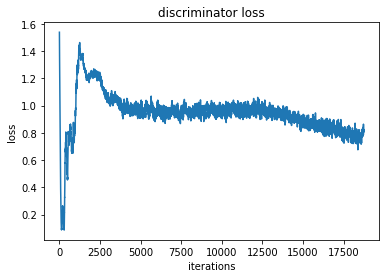

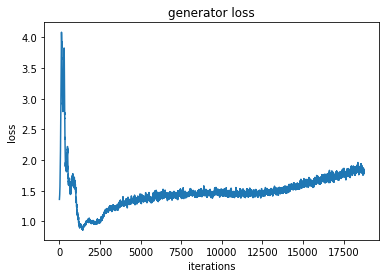

Iteration 18750/23430: dis loss = 0.7583, gen loss = 1.1150
Iteration 18800/23430: dis loss = 0.5313, gen loss = 1.7487
Iteration 18850/23430: dis loss = 0.7890, gen loss = 1.2984
Iteration 18900/23430: dis loss = 0.7322, gen loss = 1.6351
Iteration 18950/23430: dis loss = 1.1036, gen loss = 2.3971
Iteration 19000/23430: dis loss = 0.6567, gen loss = 2.2503
Iteration 19050/23430: dis loss = 0.9595, gen loss = 2.4807
Iteration 19100/23430: dis loss = 0.8699, gen loss = 1.6646
Iteration 19150/23430: dis loss = 0.9233, gen loss = 2.2818
Iteration 19200/23430: dis loss = 1.2957, gen loss = 0.4814
Iteration 19250/23430: dis loss = 0.5625, gen loss = 2.4009
Iteration 19300/23430: dis loss = 0.6867, gen loss = 2.2279
Iteration 19350/23430: dis loss = 0.6037, gen loss = 2.4296
Iteration 19400/23430: dis loss = 0.7714, gen loss = 1.5501
Iteration 19450/23430: dis loss = 0.9476, gen loss = 2.9690
Iteration 19500/23430: dis loss = 1.2547, gen loss = 0.4619
Iteration 19550/23430: dis loss = 0.7534

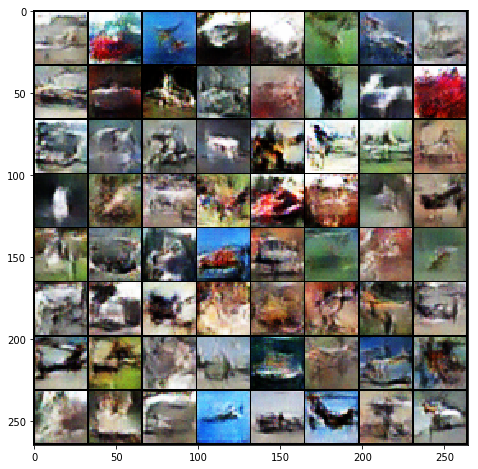

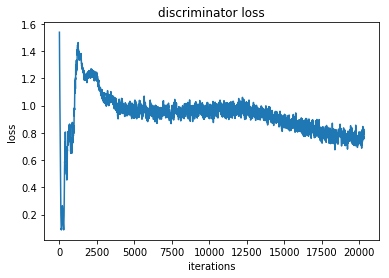

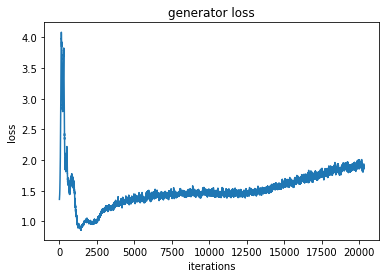

Iteration 20350/23430: dis loss = 0.8646, gen loss = 1.0448
Iteration 20400/23430: dis loss = 0.6986, gen loss = 1.5681
Iteration 20450/23430: dis loss = 0.6074, gen loss = 2.2001
Iteration 20500/23430: dis loss = 1.0579, gen loss = 3.3035
Iteration 20550/23430: dis loss = 0.9100, gen loss = 2.8890
Iteration 20600/23430: dis loss = 0.5436, gen loss = 2.4134
Iteration 20650/23430: dis loss = 0.6124, gen loss = 2.8352
Iteration 20700/23430: dis loss = 0.7475, gen loss = 1.5475
Iteration 20750/23430: dis loss = 0.6167, gen loss = 2.5069
Iteration 20800/23430: dis loss = 0.7137, gen loss = 1.9034
Iteration 20850/23430: dis loss = 0.6594, gen loss = 1.4110
Iteration 20900/23430: dis loss = 0.6334, gen loss = 2.1913
Iteration 20950/23430: dis loss = 0.5391, gen loss = 2.5183
Iteration 21000/23430: dis loss = 0.8756, gen loss = 2.0477
Iteration 21050/23430: dis loss = 0.6690, gen loss = 1.7102
Iteration 21100/23430: dis loss = 0.9599, gen loss = 2.2826
Iteration 21150/23430: dis loss = 0.8162

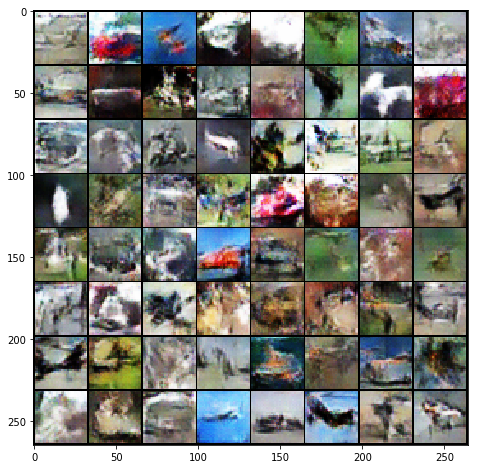

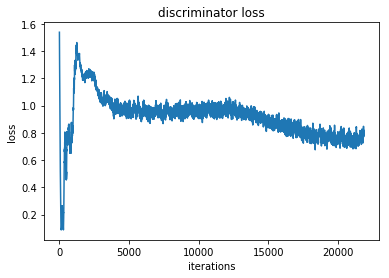

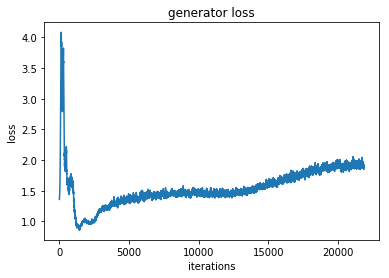

Iteration 21900/23430: dis loss = 0.5420, gen loss = 2.1044
Iteration 21950/23430: dis loss = 0.7383, gen loss = 1.3738
Iteration 22000/23430: dis loss = 0.7043, gen loss = 2.6878
Iteration 22050/23430: dis loss = 0.7570, gen loss = 2.0223
Iteration 22100/23430: dis loss = 1.1073, gen loss = 1.2601
Iteration 22150/23430: dis loss = 0.8648, gen loss = 1.1441
Iteration 22200/23430: dis loss = 0.8477, gen loss = 1.4613
Iteration 22250/23430: dis loss = 0.7052, gen loss = 2.1756
Iteration 22300/23430: dis loss = 0.6044, gen loss = 2.2858
Iteration 22350/23430: dis loss = 0.8468, gen loss = 2.0863
Iteration 22400/23430: dis loss = 0.9312, gen loss = 0.6198
Iteration 22450/23430: dis loss = 0.7409, gen loss = 3.6115
Iteration 22500/23430: dis loss = 0.7464, gen loss = 2.1982
Iteration 22550/23430: dis loss = 0.4619, gen loss = 2.2222
Iteration 22600/23430: dis loss = 0.6226, gen loss = 2.2086
Iteration 22650/23430: dis loss = 1.3398, gen loss = 3.0913
Iteration 22700/23430: dis loss = 0.5213

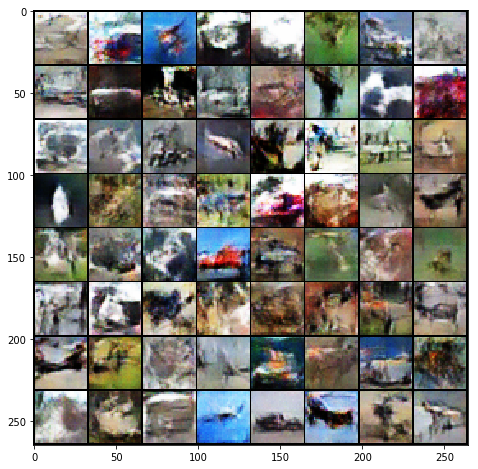

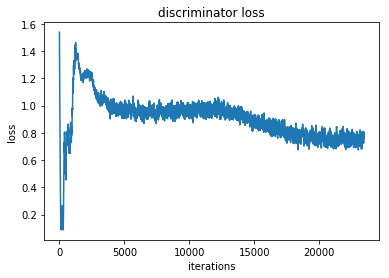

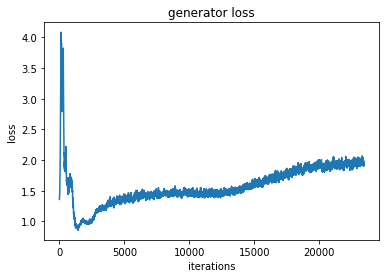

... Done!


In [5]:
tf.reset_default_graph()
set_seed(21)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')

## Problem 2-2: Activation Maximization 

GANs notoriously difficult to debug. Here we provide one of methods that are designed for investigating what networks learn, which can be helpful for debugging GANs.

Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to *[Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://arxiv.org/abs/1605.09304)*.

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code.

The batch normalization layers should work in evaluation mode.


*   **Build the computation graph for the loss:** Check the definition of these operations in ```_init_ops()```
    *   ```actmax_sample_op```: generate samples from ```actmax_code```
    *   ```actmax_loss_op```: compute discriminator's loss on samples generated from ```actmax_code```
*   **Define the optimizer:** Check the definition of ```actmax_op```, which updates ```actmax_code```
*   **Feed the data:** Check the function ```actmax_one_sample()```

W1024 12:31:33.287111 139648361588544 deprecation.py:323] From /home/hensden/usc/fall19/deeplearning/assignment2/csci566-assignment2/venv2/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


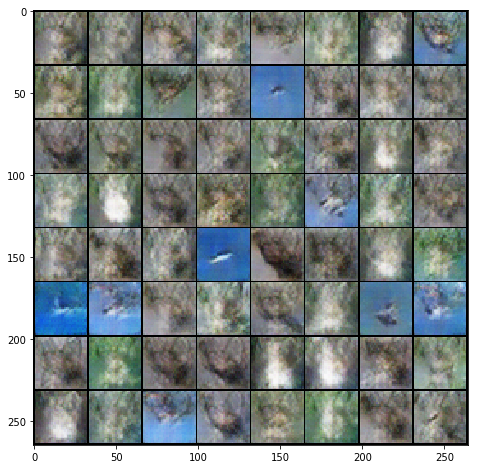

In [6]:
tf.reset_default_graph()
set_seed(241)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

The output should have less variety than those generated from random code. While it is reasonable that the samples that are "most real" makes up only a small portion of the sample space, this also gives us a hint that the so-called "mode collapse", in which the GAN simply fails to model a majority part of the data distribution, is a real problem.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the target image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.

For this part, you need to complete code blocks marked with "Prob 2-2":

*   **Build the computation graph for the loss:** Complete the definition of ```recon_loss_op``` in ```_init_ops()```, which computes the squared L2-distance between ```recon_sample``` and the sample generated from ```actmax_code```.
*   **Define the optimizer:** Modify the definition of ```reconstruct_op``` so that it updates ```actmax_code``` rather than the parameters of the networks.
*   **Feed the data:** Set the proper initial value and feed the proper data in ```reconstruct_one_sample()```

average reconstruction loss = 30.6620


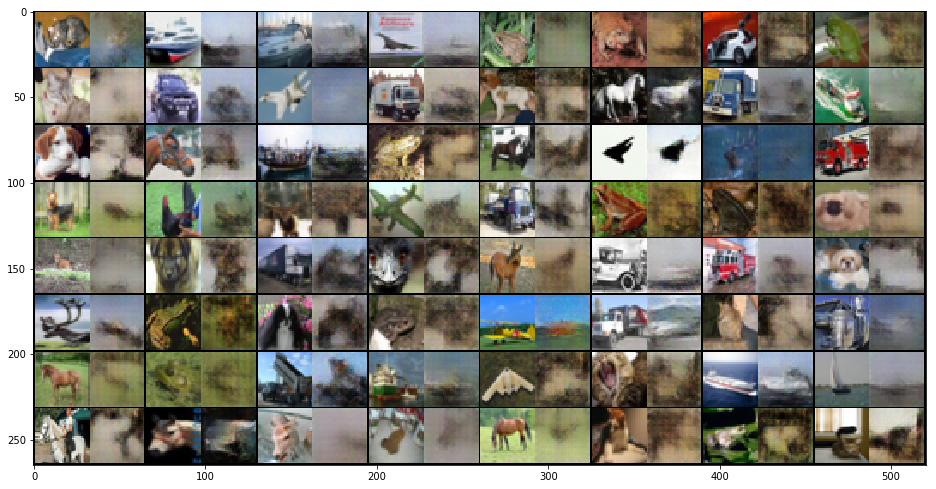

In [7]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (16, 16))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(np.concatenate((test_samples[0:64], reconstructions), axis=2), 1))
        plt.show()

Now you can see the effect of increasing the training epochs. You should be able to achieve a reconstruction loss lower than 32.